In [1]:
import os
import string
import pickle
from time import time

import numpy as np
from matplotlib import pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nnlocallinear import NLS
from explainers.visualizations.plot_importance import ExplainGraph

# Download data

In [2]:
if not os.path.isfile('./data/rt-polaritydata.tar.gz'):
    !wget 'http://www.cs.cornell.edu/People/pabo/movie-review-data/rt-polaritydata.tar.gz' -P 'data'
    !tar -xf data/rt-polaritydata.tar.gz -C 'data'

In [3]:
def load_polarity(path='./data/rt-polaritydata/'):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, np.array(labels)

x, y = load_polarity()

x[11], y[11]

('while the performances are often engaging , this loose collection of largely improvised numbers would probably have worked better as a one-hour tv documentary .',
 0)

In [4]:
remove_punct = str.maketrans('', '', string.punctuation)
remove_digits = str.maketrans('', '', string.digits)
stops = stopwords.words('english')
wnl = WordNetLemmatizer()
def process_text(sentence):
    out = sentence.lower()
    out = out.translate(remove_punct)
    out = out.translate(remove_digits)
    out = [wnl.lemmatize(w) for w in out.split() if w not in stops]
    return ' '.join(out)

In [5]:
split_idx = np.random.default_rng(0).binomial(size=len(y), n=1, p=0.8)

x_train = [process_text(x[i]) for i in range(len(x)) if split_idx[i] == 1]
x_test = [process_text(x[i]) for i in range(len(x)) if split_idx[i] == 0]

y_train = y[split_idx == 1]
y_test = y[split_idx == 0]

In [6]:
class VectorizeText():
    def __init__(self, limit=True, **kwargs):
      if limit:
        self.count_vect = CountVectorizer(min_df=0.003, max_df=0.997, **kwargs)
      else:
        self.count_vect = CountVectorizer(**kwargs)
      self.tf_transformer = TfidfTransformer(use_idf=False)
    def fit(self, x):
        x = self.count_vect.fit_transform(x)
        self.tf_transformer.fit(x)
    def transform(self, x):
        x = self.count_vect.transform(x)
        x = self.tf_transformer.transform(x)
        return x.toarray()     
    def get_feature_names(self):
        return vectorizer.count_vect.get_feature_names()
    
vectorizer = VectorizeText(limit=True)
vectorizer.fit(x_train)    
x_vec_train = vectorizer.transform(x_train) 
x_vec_test = vectorizer.transform(x_test)

names_features = np.array(vectorizer.get_feature_names())
names_features[:10], len(names_features)

(array(['act', 'acted', 'acting', 'action', 'actor', 'actress', 'actually',
        'add', 'adult', 'adventure'], dtype='<U14'),
 557)

In [39]:
def test_model(model):
    y_pred = model.predict(x_vec_test)
    print('F1 Score:', metrics.f1_score(y_test, y_pred, average='binary'))
    print('Accuracy', metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

    
def get_explanation(x_explain, document, model, num_features=10):
        
    explanation = model.get_thetas(x_pred=x_explain, net_scale=True)
    betas = explanation[2][0]
    #print('len(betas)', len(betas))
    words_from_text_indices = np.argwhere(x_explain[0] != 0).reshape(-1)
    #print('len(words_from_text_indices)', len(words_from_text_indices))
    # Prediction from the model
    prediction = model.predict(x_explain).reshape(-1)
    predict_proba = model.predict_proba(x_explain).reshape(-1)
    ind_pred_proba = np.argsort(predict_proba)[::-1]
    #print('probabilities: ', ind_pred_proba)

    print(f'Probability negative: {predict_proba[0]}; Probability positive: {predict_proba[1]}')
    # col_betas = int(prediction)
    col_betas = ind_pred_proba[0]
    col_betas_neg = ind_pred_proba[1]

    betas_document = betas[words_from_text_indices, col_betas]
    #print('betas_document len:', len(betas_document))
    betas_document_neg = betas[words_from_text_indices, col_betas_neg]

    betas_final = betas_document - betas_document_neg
    words_features_document = names_features[words_from_text_indices].reshape(-1)

    return dict(
        chi_names=words_features_document,
        chi_values=words_features_document,
        x_values=words_features_document,
        x_names=words_features_document,
        y_p=predict_proba[0],
        y_p_max=1.0,
        y_p_min=0.0,
        y_p_local_model=predict_proba[0],
        y_p_local_model_max=None,
        y_p_local_model_min=None,
        error=None,
        importances=betas_final,
        importances_rank1=betas_document,
        importances_rank2=betas_document_neg, 
        diff_convergence_importances=None,
        ind_class_sorted=0,
        class_names= ["probability"]
    )


def train(penalization_thetas, x_train, y_train):
    parameters = {
        'es_give_up_after_nepochs': 50
        , 'hidden_size': 100
        , 'num_layers': 5
        , 'n_classification_labels': 2
        , 'penalization_thetas': penalization_thetas
    }
    model = NLS(
        verbose=10
        , es=True
        , batch_initial=16
        , batch_max_size=128
        , gpu=True
        , scale_data=False
        , varying_theta0=False
        , fixed_theta0=True
        , dataloader_workers=0
        , **parameters
    )
    model.fit(x_train=x_train, y_train=y_train)
    test_model(model)
    return model

def explanation(sentence, x, x_vec, model):
    print(f'Original sentence: {sentence}')
    print(f'Tokenized sentence: {x}')
    
    feature_names=[f'{e}: {word}' for e, word in enumerate(x.split())]
    words=np.array([f'{word}' for e, word in enumerate(x.split())])
    
    explain_dict = get_explanation(x_vec, sentence, model, num_features=13)
    
    fig, ax = plt.subplots(figsize=(8, 9))
    ax.set_title('Importance', fontsize=25)
    names = explain_dict['chi_names']
    importances = explain_dict['importances']
    ax = ExplainGraph.plot_feature_importance(ax=ax, names=names, vals=importances, size_title=15)
    plt.savefig(f'./img/rotten_tomatos/{penalization_thetas}.pdf', dpi=300)
    plt.show()

In [ ]:
start = time()
penalization_thetas = 100000
model = train(penalization_thetas, x_vec_train, y_train)
delta_time = time() - start 
"Time: ", delta_time

Finished epoch 0 with batch size 16 and train loss 16670231656.435146


## Explanations from data

Original sentence: a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .
Tokenized sentence: visually flashy narratively opaque emotionally vapid exercise style mystification
Probability negative: 0.5556545257568359; Probability positive: 0.44434547424316406


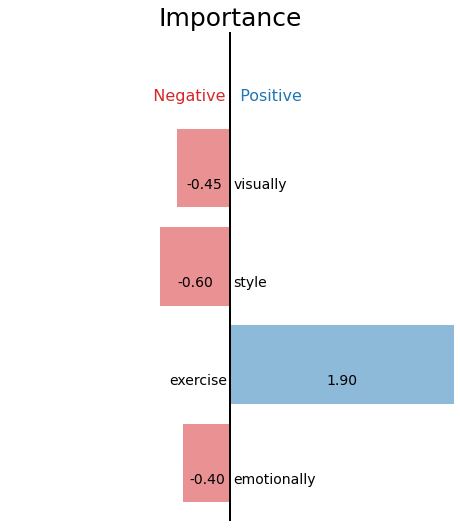

In [37]:
i = 0
explanation(sentence = x[np.where(split_idx == 0)[0][i]], x = x_test[i], x_vec = np.array([x_vec_test[i]]), model = model)

## Example explanations

Original sentence: very fun movie, great actors.
Tokenized sentence: fun movie great actor
Probability negative: 0.18561933934688568; Probability positive: 0.8143807053565979


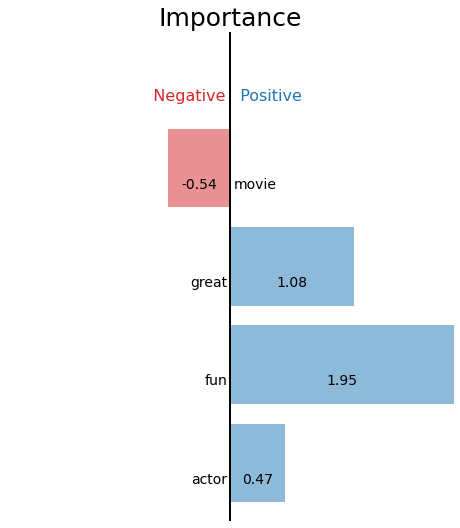

In [38]:
sentence = 'very fun movie, great actors.'
x_ = process_text(sentence)
x__vec = vectorizer.transform([x_])
explanation(sentence, x_, x__vec, model)

In [ ]:
for penalization_thetas in [100, 1000, 10000, 100000]: # + list(range(10, 40, 5)) + list(range(50, 201, 50)):
    print('\n'*2)
    print('#'*30)
    print('penalization_thetas:', penalization_thetas)
    train_test_explain(penalization_thetas, x_vec_train, y_train, x_vec_explain, x_explain)